In [20]:
import matplotlib.pyplot as plt
from matplotlib import interactive
import numpy as np
import os
import subprocess
from joint_can import *
import time
%matplotlib widget

Parametry diagnostyki:

In [37]:
tq=16. #zadawany moment obrotowy (konieczna kropka na końcu jeżeli jest to liczba całkowita) 16 dla J25, 8 dla J20
serial="JANUSZ_3_RI80_21414855" #musi byc min jedna litera w numerze
note="znalezny" #póki co musi być cokolwiek

In [38]:
path = "/home/ubuntu/joint_diagnostic/diagnostic_data/"

Ścieżka pliku do wyrysowania:

(Diagnostyka zostanie uruchomiona jedynie gdy target_file="")

In [18]:
target_file=""

Ścieżka pliku referencyjnego:

In [19]:
ref_file=""

# Ustawienie temperatury

In [6]:
def initialize_joint(bus):
    send_msg(0x0A0, None, bus)
    time.sleep(1)
    
    send_msg(0x0b0, [0,0,0,0,0,0], bus)
    time.sleep(0.1)
    send_msg(0x040, None, bus)
    time.sleep(0.1)
    send_msg(0x0a0, None, bus)
    time.sleep(1)
    
    if (send_msg(0x0F0, [2, 2], bus).data[0] == 1):
        send_msg(0x010, [2], bus)
        time.sleep(1)
        print(send_msg(0x010, [3], bus).data[0])
        time.sleep(5)
        return True
    else:
        return False
     

In [7]:
os.popen('/home/ubuntu/can_down.sh')
time.sleep(1)
os.popen('/home/ubuntu/can_up.sh')
time.sleep(1)

bus = can.interface.Bus(bustype='socketcan', channel='can0', bitrate=1000000, data_bitrate=5000000, fd=True)
initialize_joint(bus)

2


True

parametry temperatury

In [8]:
min_temp = 30
max_temp = 31
speed = 1. #predkosc na ktorej joint jest rozgrzewany

In [9]:
c_speed=0.
j_data=set_speed(c_speed,bus)

while(j_data.bearing_temp<min_temp or j_data.bearing_temp>max_temp):
    if j_data.bearing_temp<min_temp:
        c_speed=speed
    else:
        c_speed=0.
    j_data=set_speed(c_speed,bus)
    print(f'\r tq: {j_data.torque:.3f}\tm_temp: {j_data.motor_temp:.3f}\tb_temp: {j_data.bearing_temp:.3f}', end='')
    time.sleep(1)
send_msg(0x0A0, None, bus)

 tq: 15.414	m_temp: 33.000	b_temp: 30.000

# Diagnostyka

In [10]:
try: 
    os.mkdir(path+'/'+serial) 
except OSError as error: 
    pass

In [11]:
if not len(target_file):
    # stream = os.popen('/home/ubuntu/run_diag.sh '+str(tq)+' '+str(serial)+' \"'+str(note)+'\"')
    initialize_joint(bus)
    subprocess.Popen(['/home/ubuntu/run_diag.sh',str(tq),str(serial),' \"'+str(note)+'\"']).communicate()[0]
    # output = stream.read()
    # print(output)

2
launching diagnostics with 16.0 torque
[INFO] [launch]: All log files can be found below /home/ubuntu/.ros/log/2022-07-27-11-42-53-817209-ubuntu-86127
[INFO] [launch]: Default logging verbosity is set to INFO
[INFO] [hw_interface-1]: process started with pid [86129]
[INFO] [diagnostics-2]: process started with pid [86131]
[hw_interface-1] Opening CAN socket...
[hw_interface-1] Configuring IO...
[hw_interface-1] Successfully configured IO.
[hw_interface-1] Clear shared memory location
[hw_interface-1] Allocating 880 bytes
[hw_interface-1] Create shared memory location
[hw_interface-1] Create shared memory variables
[diagnostics-2] [INFO] [1658922174.236845817] [base_controller]: Initialization watchdog for module "base_controller"
[hw_interface-1] Done initializing shared memory
[hw_interface-1] 17333
[hw_interface-1] Initializing connection with CAN.
[hw_interface-1] Established connection with CAN
[hw_interface-1] Arm connection initialization successfull.
[hw_interface-1] Starting 

# Wykresy

In [21]:
plt.rcParams['figure.figsize'] = [12, 8]

Zakres dopuszczalnej prędkości

In [22]:
v_min=0.25
v_max=0.45

In [39]:
flist=os.listdir(path+'/'+serial)
flist.sort()
flist.reverse()
ref_data=[]
            
            
for fname in flist:
    if '.txt' not in fname:
        flist.remove(fname)

if len(ref_file):
    rfname=ref_file+'.txt'
    data_points = []
    with open(path+'/'+serial+'/'+rfname) as file:
        ref_data = (list(file))

        if "serial number: " in ref_data[0]:
            rf_serial = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_serial = ''

        if "torque: " in ref_data[0]:
            rf_tq = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_tq = ''

        if "start_temp: " in ref_data[0]:
            rf_temp1 = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_temp1 = ''

        if "finish_temp: " in ref_data[0]:
            rf_temp2 = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_temp2 = ''

        if "note: " in ref_data[0]:
            rf_note = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_note = ''

        ref_data = [point.split() for point in ref_data]

        ref_data = np.array(ref_data, dtype=float)
        


Wykresy prędkości przy stałym momencie:

/tmp/ipykernel_86045/160543535.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, a = plt.subplots(subplot_kw={'projection': 'polar'}, )


ValueError: zero-size array to reduction operation maximum which has no identity

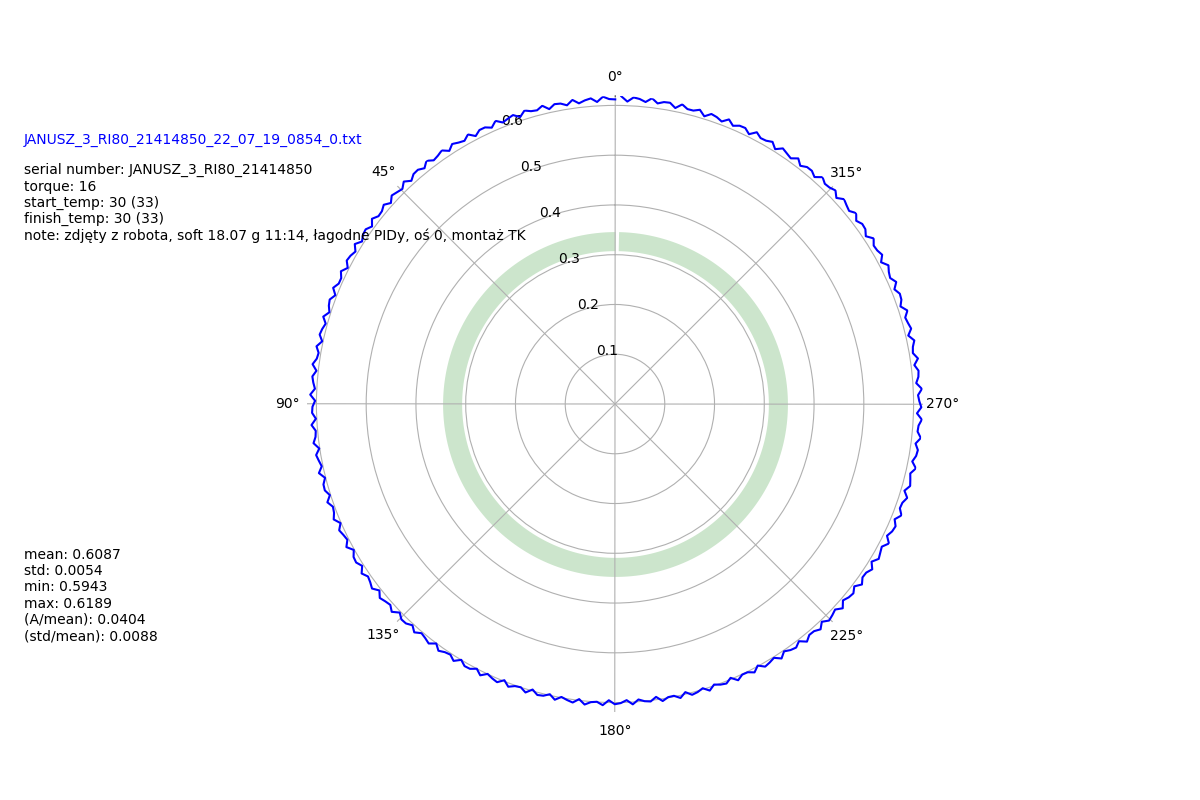

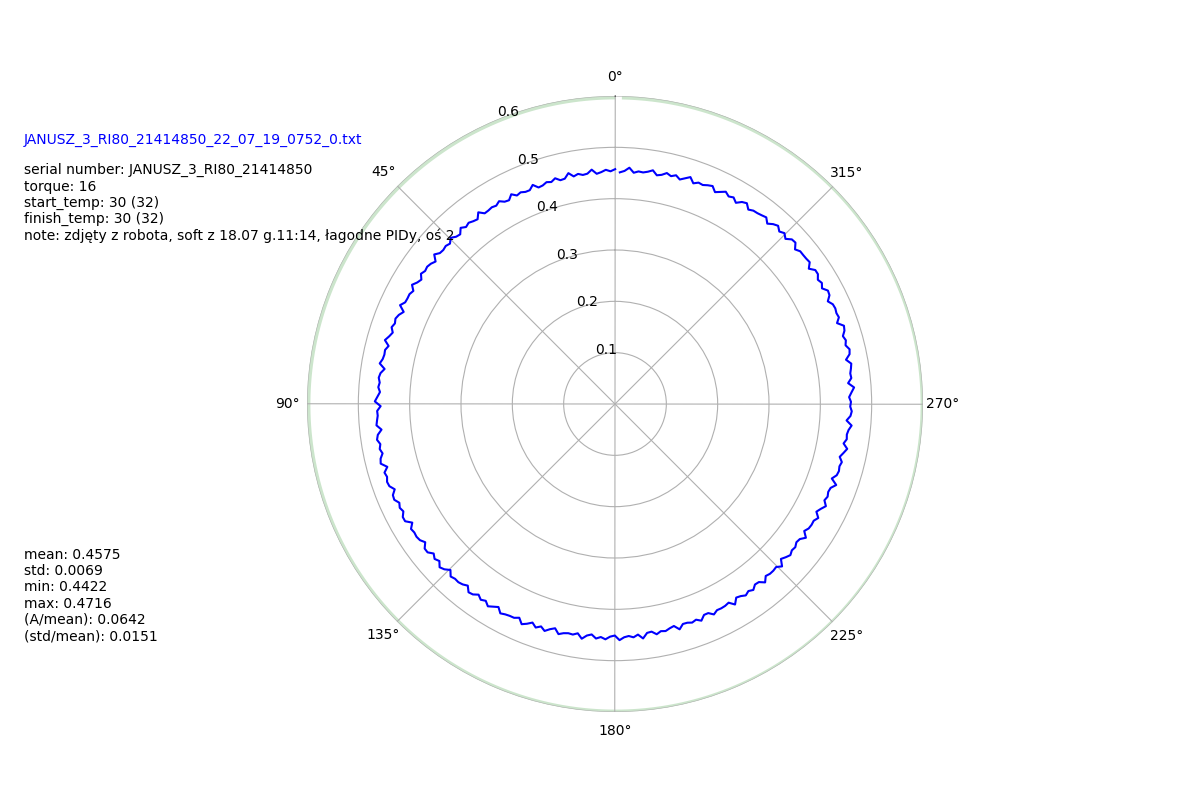

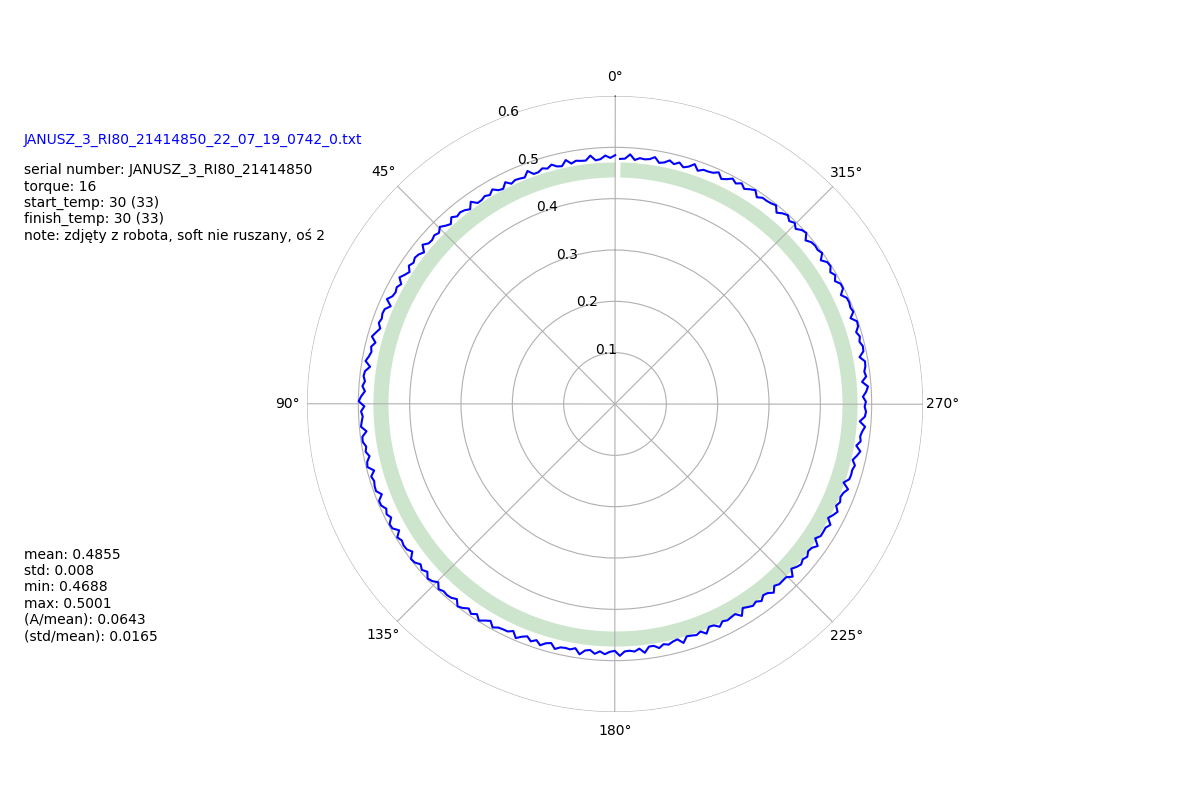

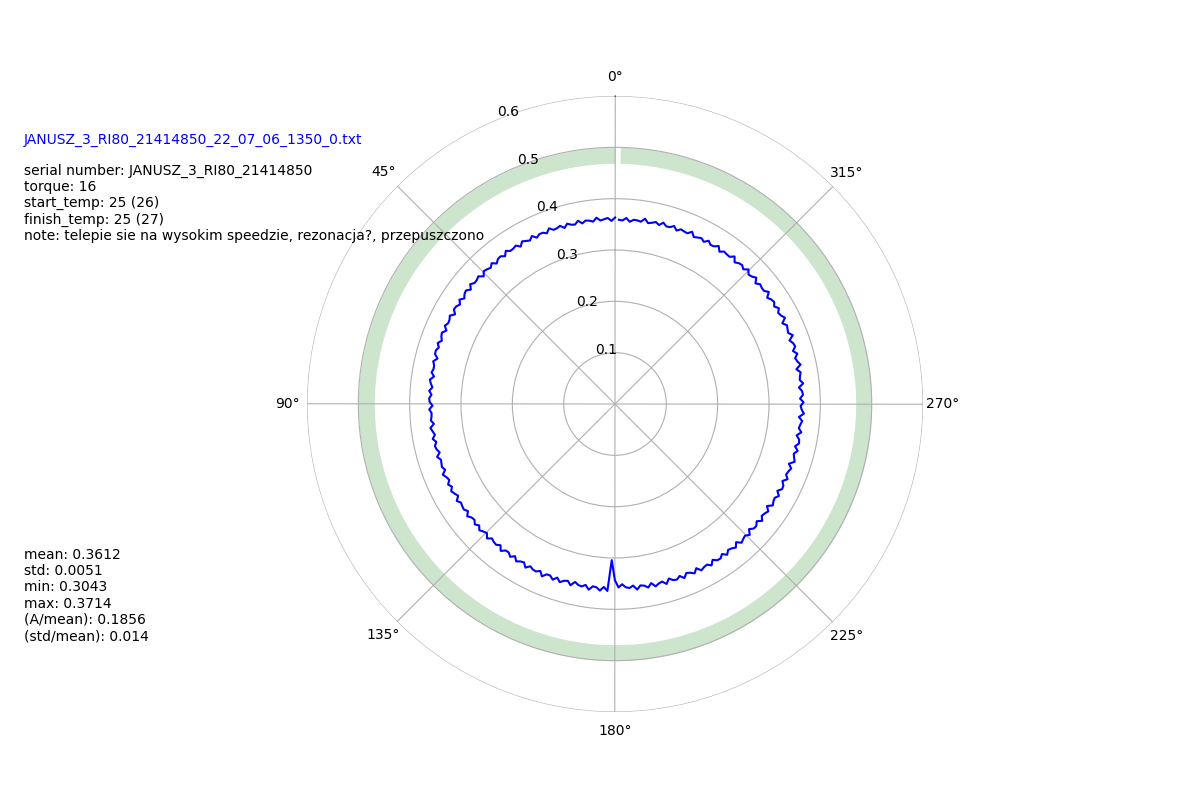

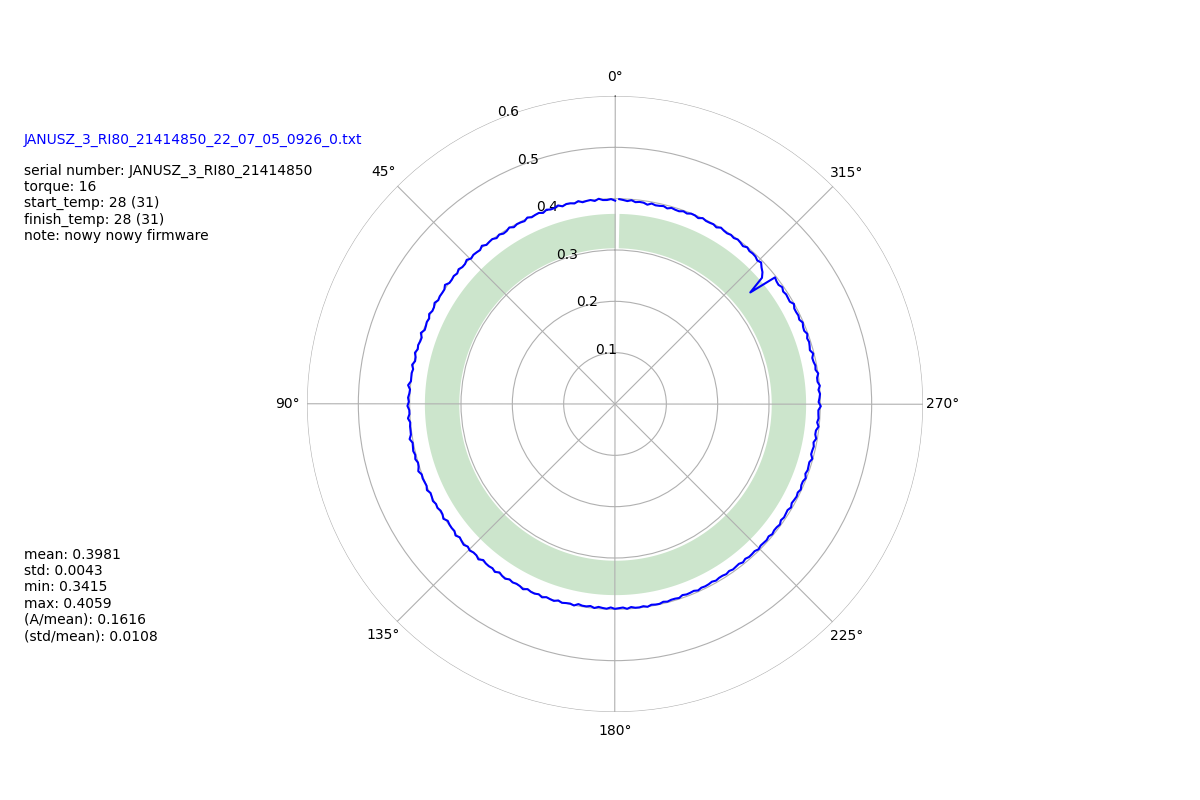

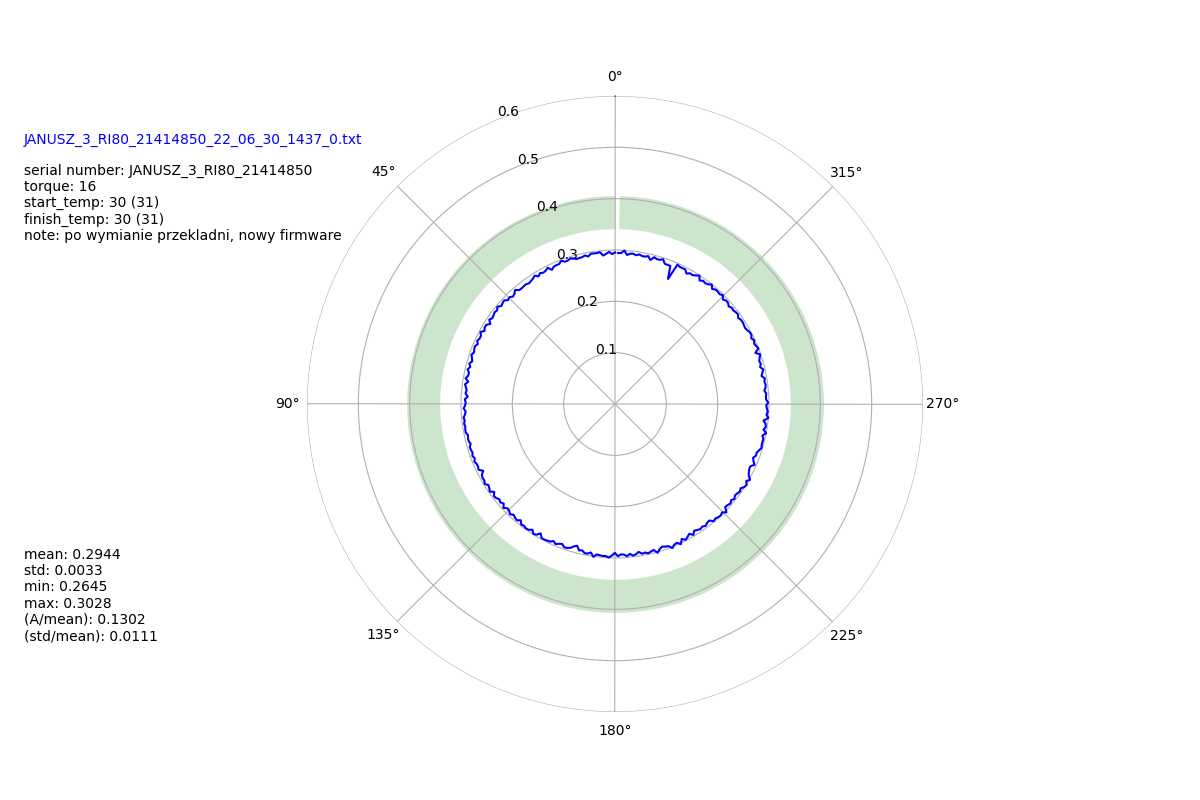

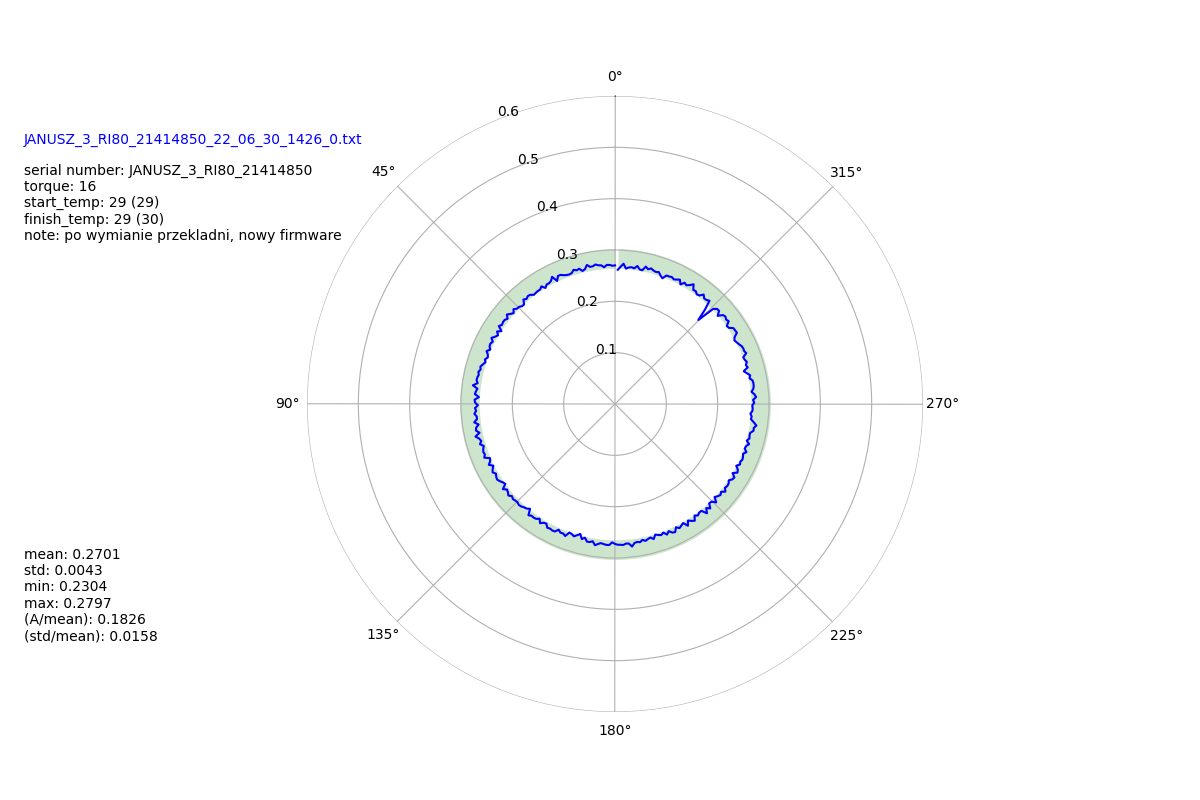

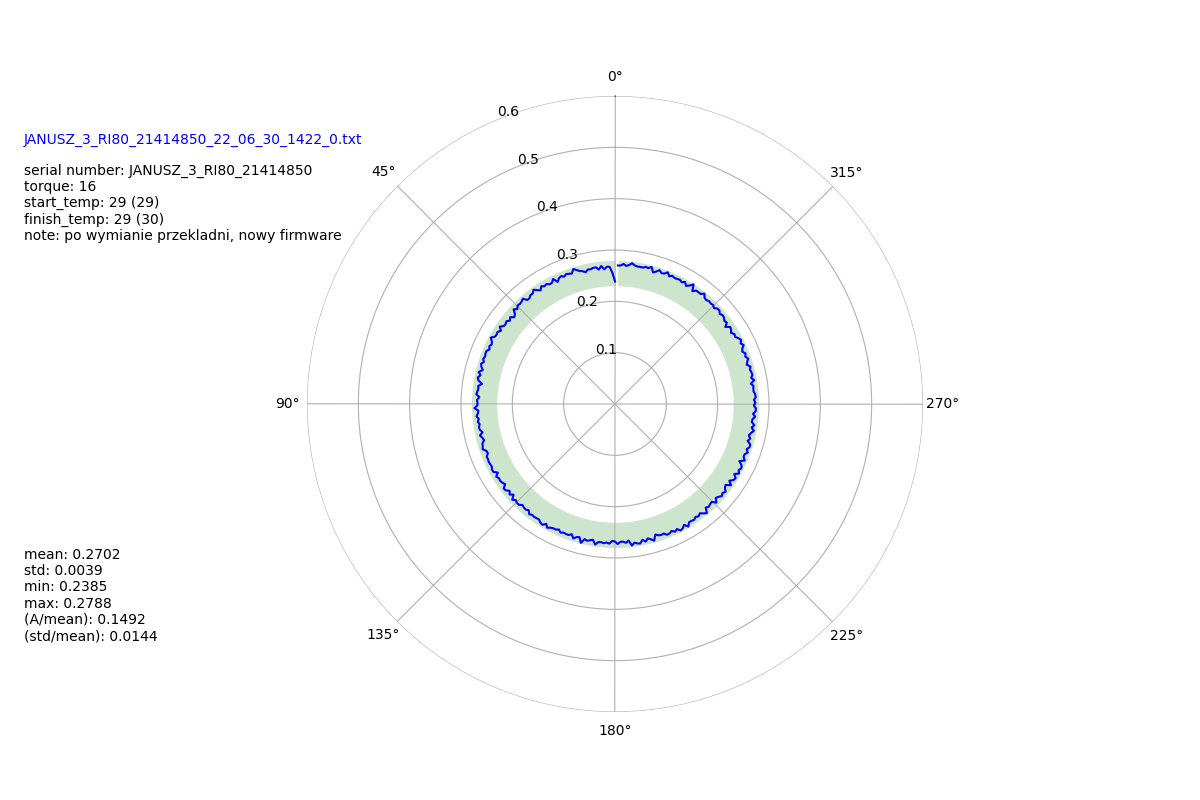

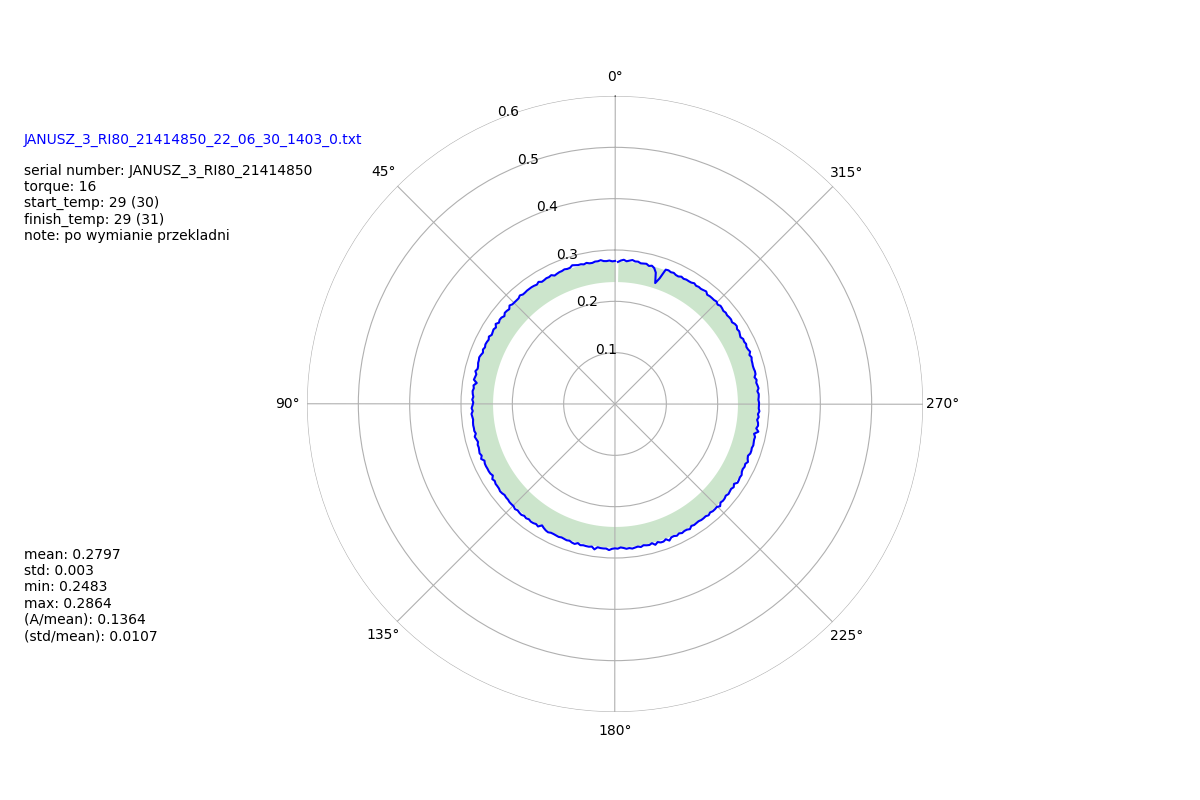

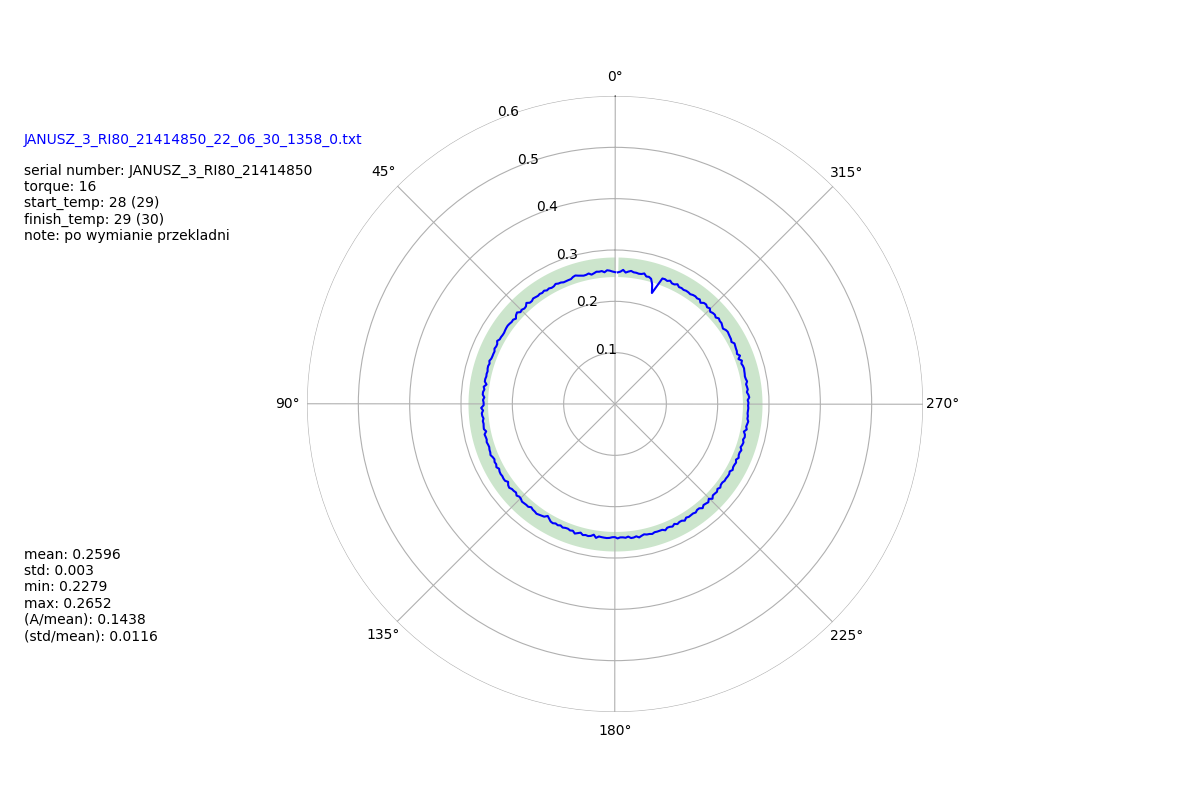

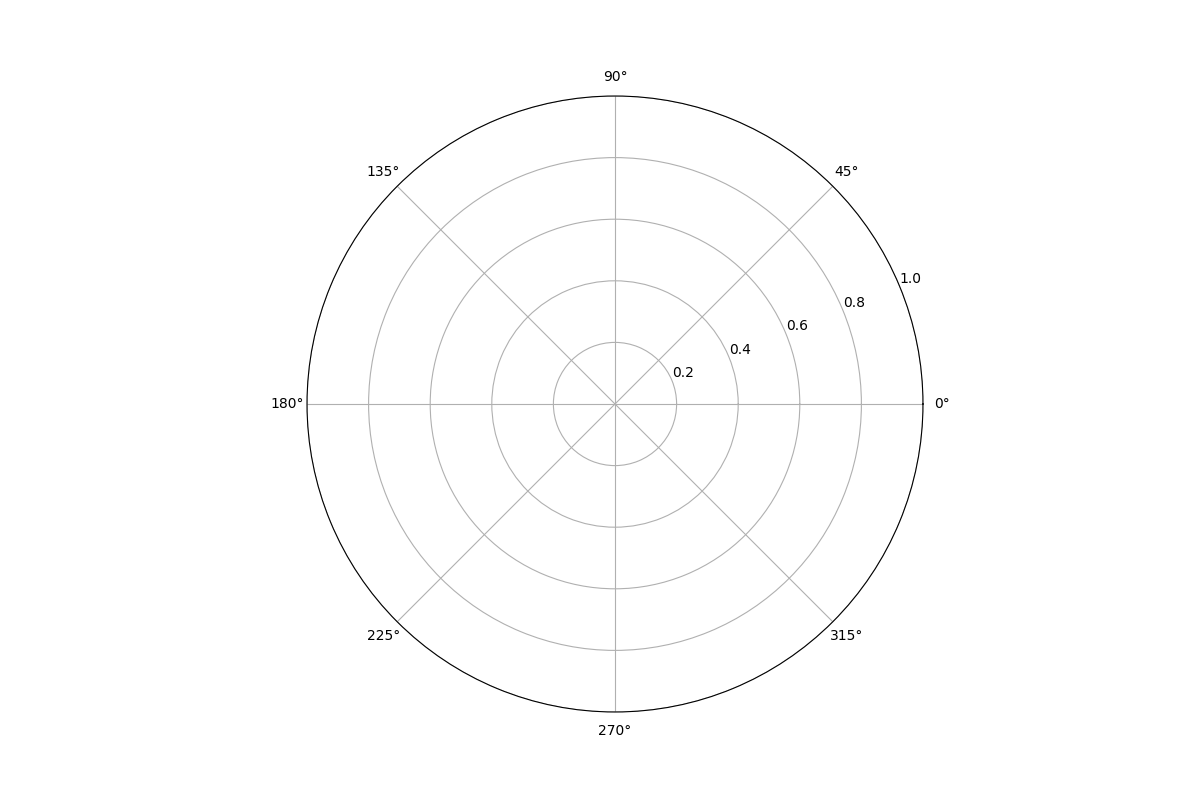

In [40]:
if target_file[-4:]!='.txt':
    target_file=target_file+".txt"

for fname in flist:
    # if len(target_file):
    #     if target_file != fname:
    #         continue
    if serial in fname and '.txt' in fname or fname == target_file:
        data_points = []
        with open(path+'/'+serial+'/'+fname) as file:
            data_points+=(list(file))
            
        f, a = plt.subplots(subplot_kw={'projection': 'polar'}, )

        
        if "serial number: " in data_points[0]:
            r_serial=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_serial=''
            
        if "torque: " in data_points[0]:
            r_tq=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_tq=''
            
        if "start_temp: " in data_points[0]:
            r_temp1=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_temp1=''
            
        if "finish_temp: " in data_points[0]:
            r_temp2=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_temp2=''
        
        if "note: " in data_points[0]:
            r_note=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_note=''
            
        data_points=[point.split() for point in data_points]
        
        
        data_points=np.array(data_points,dtype=float)
        
        data_points = data_points[~np.isnan(data_points[:,1])]
        
        if len(ref_data):
            a.set_ylim(0,max(0.6,data_points[:,1].max(),ref_data[:,1].max())) #zakres predkosci wykresu
        else:
            a.set_ylim(0,max(0.6,data_points[:,1].max())) #zakres predkosci wykresu
                
        a.set_theta_offset(1.57)
        
        a.plot(data_points[:, 0], data_points[:, 1],color='blue')
        
        a.fill_between(data_points[:,0],v_min,v_max,alpha=0.2,linewidth=0,color='green')
        
        v_min = data_points[:,1].min()
        v_max = data_points[:,1].max()
        v_mean = np.nanmean(data_points[:,1])
        v_std = np.nanstd(data_points[:,1])
        v_A = (v_max-v_min)
        
        # f.suptitle("Joint "+str(fname))
        # a.set_title(str(r_tq)+' '+str(r_temp1)+' '+str(r_temp2))
        plt.figtext(0.02,0.82,str(fname),color = 'blue')
        plt.figtext(0.02,0.7,r_serial+'\n'+r_tq+'\n'+r_temp1+'\n'+r_temp2+'\n'+r_note)
        plt.figtext(0.02,0.2,'mean: '+ str(round(v_mean,4))+'\nstd: '+str(round(v_std,4))+'\nmin: '+ str(round(v_min,4))+'\nmax: '+ str(round(v_max,4))+'\n(A/mean): ' + str(round(v_A/v_mean,4)) + '\n(std/mean): ' + str(round(v_std/v_mean,4)))
        
        if len(ref_data):
            a.plot(ref_data[:, 0], ref_data[:, 1],alpha=0.8,color='green')
            plt.figtext(0.78,0.82,str(rfname),color = 'green')
            plt.figtext(0.78,0.7,rf_serial+'\n'+rf_tq+'\n'+rf_temp1+'\n'+rf_temp2+'\n'+rf_note)
            plt.figtext(0.78,0.2,'mean: '+ str(round(np.nanmean(ref_data[:,1]),4))+'\nstd: '+str(round(np.nanstd(ref_data[:,1]),4))+'\nmin: '+ str(round(ref_data[:,1].min(),4))+'\nmax: '+ str(round(ref_data[:,1].max(),4)))
        
        if len(target_file) and len(ref_data):
            plt.savefig( path+'/'+serial+'/'+fname[:-4] + "_comp.png", dpi=150)
        else:
            plt.savefig( path+'/'+serial+'/'+fname[:-4] + ".png", dpi=150)                